<a href="https://colab.research.google.com/github/liao771018/Team-Project/blob/main/TeamProject_ResNet152_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import applications, layers, models, losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare dataset

In [ ]:
# 模型要用的圖片大小
IMG_SIZE = 224

# 模型檔名
model_name = 'ResNet152_v2_TP_2.h5'

# 記錄檔名
log_name = 'ResNet152_v2_logs_2.csv'

# 模型存檔的位置
save_model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/05_ResNet152_v2'

model_path = save_model_path + '/' + model_name
log_path = save_model_path + '/' + log_name

In [ ]:
# 讀取資料
img_dir = '/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片'

trains = glob(img_dir + '/train/*')
tests = glob(img_dir + '/test/*')

print('train:', len(trains))
print('test:', len(tests))

train: 6089
test: 838


/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片/train/cuttlefish_photo_00616.jpg
shape: (453, 604, 3)
resize: (224, 224, 3)
class: cuttlefish


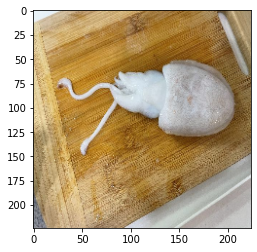

In [ ]:
# show image
idx = np.random.randint(0, len(trains))
print(trains[idx])

# cv2 讀取是 BGR plt 顯示是 RGB
img = cv2.imread(trains[idx])[:,:,::-1]
print('shape:', img.shape)

# Resize img
img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
print('resize:', img_resize.shape)

cls = trains[idx].split('/')[-1].split('_')[0]
print('class:', cls)

plt.imshow(img_resize)

In [ ]:
# 把題目跟答案做成 DataFrame
train_df = pd.DataFrame({
              'img_path': trains,                  
})
test_df = pd.DataFrame({
              'img_path': tests
})


def ans(img_path):
  # 取出藏在檔名的答案
  # /content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片/train/cuttlefish_photo_00616.jpg
  label = img_path.split('/')[-1].split('_')[0]
  return label


train_df['label'] = train_df['img_path'].apply(ans)
test_df['label'] = test_df['img_path'].apply(ans)

train_df

,img_path,label
0,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
1,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
2,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
3,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
4,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
...,...,...
6084,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
6085,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
6086,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
6087,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus


In [ ]:
# 轉換答案的字典
cls = train_df['label'].unique()

cls2idx = {c: i for i, c in enumerate(cls)}
idx2cls = {i: c for i, c in enumerate(cls)}

cls2idx, idx2cls

({'bigfin squid': 0,
  'cuttlefish': 4,
  'neritic squid': 1,
  'octopus': 2,
  'squid': 3},
 {0: 'bigfin squid',
  1: 'neritic squid',
  2: 'octopus',
  3: 'squid',
  4: 'cuttlefish'})

In [ ]:
# 準備 train / validation / test  全部轉 np.array

x_train_path = np.array(train_df['img_path'])
y_train = np.array(train_df['label'].replace(cls2idx))

x_test_path = np.array(test_df['img_path'])
y_test = np.array(test_df['label'].replace(cls2idx))

# 從 train 裡面切分 validation 出來
x_train_path, x_val_path, y_train, y_val = train_test_split(x_train_path, y_train, test_size=0.1)
# train : 6089
# test : 838

# 看一下 shape 是否一樣
x_train_path.shape, y_train.shape, x_val_path.shape, y_val.shape, x_test_path.shape, y_test.shape

((5480,), (5480,), (609,), (609,), (838,), (838,))

In [ ]:
# 建立批次讀圖後送進模型的函式

def get_data(x, y, batch=None):
    # x : 圖片路徑
    # y : 答案

    # 如果不是 None, 那代表是數字，取出這個數量的 idx
    # 範例 batch=20, 隨機 20 個idx
    # 如果是 None, 那就沒有隨機取, 取全部 idx
    if batch is not None:

      idx = np.random.randint(0, len(x), size=batch) # 在(0, len(x))取隨機的 size 個數 (可能取到重覆的)
      x, y = x[idx], y[idx]
      # 這時候 x, y 會是一批隨機的資料
    
    # img_pre: preprocess後的圖
    # img_ori: 原圖
    img_pre, img_ori = [], []

    for p in x:

      img = cv2.imread(p)[:,:,::-1]
      img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
      img = np.array(img)
      img_pre.append(applications.resnet_v2.preprocess_input(img))
      img_ori.append(img)

    return (np.array(img_pre), np.array(img_ori), y)
    

In [ ]:
# 把 validation 全部讀出來
x_val, _, y_val = get_data(x_val_path, y_val)

x_val.shape, y_val.shape

((609, 224, 224, 3), (609,))

#Build Model

In [ ]:
resnet152_v2 = tf.keras.applications.resnet_v2.ResNet152V2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet152_v2.summary()

234561536/234545216 [==============================] - 7s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [ ]:
# params change non_trainable
for l in resnet152_v2.layers:
    l.trainable = False

# 加入自己的分類器 (上面已有 BN 層，這裡可以先不加試試看)
x = layers.BatchNormalization()(resnet152_v2.output)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(len(cls2idx), activation='softmax')(x)

model = models.Model(inputs=resnet152_v2.input, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# 選擇損失函數
model.compile( loss=losses.SparseCategoricalCrossentropy(),
        optimizer='adam',
        metrics=['accuracy']
)

#Training

In [ ]:
# EarlyStoppong 條件
stopping = 10
min_val_loss, best_val_accuracy = float("inf"), 0

# 要跑的數量
epoch = 100
batch = 50

# 一個 epoch 需要跑的 batch 次數
counts = int(len(trains)/batch) + 1

# 把紀錄蒐集起來
loss = []
accuracy = []
val_loss = []
val_accuracy = []


for e in range(epoch):

    total_loss, total_accuracy = 0, 0
    print('Epoch:', e+1, '/', epoch, end='\t')
        
    for b in tqdm(range(counts)):

        # 讀取資料
        x, _, y = get_data(x_train_path, y_train, batch=batch) 

        # 以 batch 方式做訓練
        batch_loss, batch_accuracy = model.train_on_batch(x, y)
        
        total_loss += batch_loss
        total_accuracy += batch_accuracy

    # 把每一次 batch 的 loss, accuracy 做平均後放進 list
    batch_avg_loss = total_loss / counts
    batch_avg_accuracy = total_accuracy / counts

    # test
    epoch_val_loss, epoch_val_accuracy = model.test_on_batch(x_val, y_val)

    # 印出 loss, accuracy, val_loss, val_accuracy
    print("loss: {:.4f} - accuracy: {:.4f}".format(batch_avg_loss, batch_avg_accuracy), end=' - ')
    print("val_loss: {:.4f} - val_accuracy: {:.4f}".format(epoch_val_loss, epoch_val_accuracy))
    print('-' * 100)

    # 把四個值放進 list 做紀錄
    loss.append(batch_avg_loss)
    accuracy.append(batch_avg_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)

    # 啟動 EarlyStopping 條件
    if epoch_val_loss < min_val_loss:

        min_val_loss, best_val_accuracy = epoch_val_loss, epoch_val_accuracy
        patience = 0
        model.save(model_path)

    else:
        patience = patience + 1

    if patience == stopping:
        break   

print('\nThe Best', end='\n')
print("val_loss:", min_val_loss, '-', 'val_accuracy:', best_val_accuracy)

# 7/16 (2cls) best val_loss: 0.011879620142281055 - val_accuracy: 0.9948453903198242
# 7/19 (5cls) best val_loss: 0.14420536160469055 - val_accuracy: 0.9605911374092102

Epoch: 1 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.2813 - accuracy: 0.9041 - val_loss: 0.2263 - val_accuracy: 0.9278
----------------------------------------------------------------------------------------------------
Epoch: 2 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0743 - accuracy: 0.9800 - val_loss: 0.1762 - val_accuracy: 0.9343
----------------------------------------------------------------------------------------------------
Epoch: 3 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0354 - accuracy: 0.9911 - val_loss: 0.1893 - val_accuracy: 0.9392
----------------------------------------------------------------------------------------------------
Epoch: 4 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0202 - accuracy: 0.9964 - val_loss: 0.1507 - val_accuracy: 0.9507
----------------------------------------------------------------------------------------------------
Epoch: 5 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0144 - accuracy: 0.9970 - val_loss: 0.1492 - val_accuracy: 0.9425
----------------------------------------------------------------------------------------------------
Epoch: 6 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0113 - accuracy: 0.9979 - val_loss: 0.1729 - val_accuracy: 0.9475
----------------------------------------------------------------------------------------------------
Epoch: 7 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0062 - accuracy: 0.9992 - val_loss: 0.1630 - val_accuracy: 0.9458
----------------------------------------------------------------------------------------------------
Epoch: 8 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.1727 - val_accuracy: 0.9491
----------------------------------------------------------------------------------------------------
Epoch: 9 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.1602 - val_accuracy: 0.9458
----------------------------------------------------------------------------------------------------
Epoch: 10 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.1554 - val_accuracy: 0.9442
----------------------------------------------------------------------------------------------------
Epoch: 11 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.1717 - val_accuracy: 0.9392
----------------------------------------------------------------------------------------------------
Epoch: 12 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1746 - val_accuracy: 0.9442
----------------------------------------------------------------------------------------------------
Epoch: 13 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.1714 - val_accuracy: 0.9425
----------------------------------------------------------------------------------------------------
Epoch: 14 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.1742 - val_accuracy: 0.9442
----------------------------------------------------------------------------------------------------
Epoch: 15 / 100	

  0%|          | 0/122 [00:00<?, ?it/s]

loss: 0.0035 - accuracy: 0.9987 - val_loss: 0.1855 - val_accuracy: 0.9507
----------------------------------------------------------------------------------------------------

The Best
val_loss: 0.14921030402183533 - val_accuracy: 0.9425287246704102


# Metrics

In [ ]:
df = pd.DataFrame({
        "loss" : loss,
        "accuracy" : accuracy,
        "val_loss" : val_loss,
        "val_accuracy" : val_accuracy
})

df.to_csv(log_path)
df

,loss,accuracy,val_loss,val_accuracy
0,0.281254,0.904098,0.226331,0.927750
1,0.074308,0.980000,0.176151,0.934319
2,0.035389,0.991148,0.189316,0.939245
3,0.020160,0.996393,0.150736,0.950739
4,0.014367,0.997049,0.149210,0.942529
5,0.011288,0.997869,0.172898,0.947455
6,0.006164,0.999180,0.163022,0.945813
7,0.006368,0.998525,0.172738,0.949097
8,0.006044,0.998852,0.160187,0.945813
9,0.005884,0.999016,0.155432,0.944171


In [ ]:
x_test, x_test_ori, y_test = get_data(x_test_path, y_test)
x_test.shape, y_test.shape

((838, 224, 224, 3), (838,))

In [ ]:
model = models.load_model(model_path)
model.evaluate(x_test, y_test)
# 7/16 (2cls) loss: 0.0303 - accuracy: 0.9832
# 7/19 (5cls) loss: 0.1145 - accuracy: 0.9666

27/27 [==============================] - 10s 244ms/step - loss: 0.1059 - accuracy: 0.9678


[0.10589919984340668, 0.9677804112434387]

In [ ]:
# 混淆矩陣
pre = model.predict(x_test).argmax(axis=-1)
mat = confusion_matrix(y_test, pre)

pd.DataFrame(mat,
      columns=['{}預測'.format(i) for i in cls2idx],
      index=['{}真實'.format(i) for i in cls2idx])


,bigfin squid預測,neritic squid預測,octopus預測,squid預測,cuttlefish預測
bigfin squid真實,161,3,1,0,4
neritic squid真實,1,188,0,3,0
octopus真實,2,0,241,1,3
squid真實,1,0,0,82,1
cuttlefish真實,4,0,2,1,139


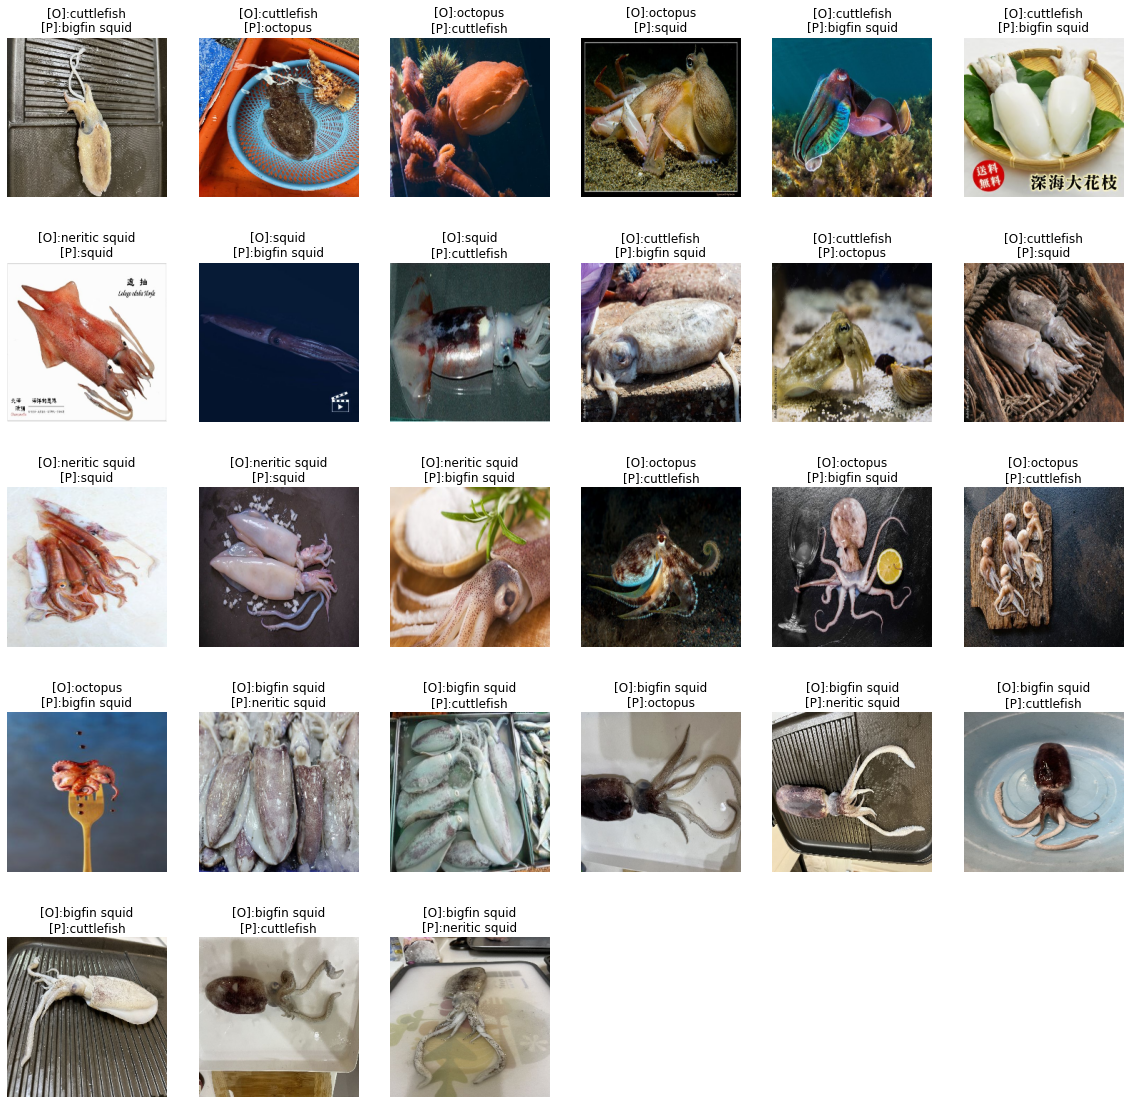

In [ ]:
# 預測錯誤的 index
idx = np.nonzero(pre != y_test)[0]

# 預測錯誤的 圖 正確值 與 預測值
pre_false_img = x_test_ori[idx]
pre_false_label = y_test[idx]
pre_false_pred = pre[idx]

# 設定圖的大小
plt.figure(figsize=(20,20))
width = 6
height = len(idx) // width + 1


# 印出來看一下預測錯誤的圖
for i in range(len(idx)):

    plt.subplot(height, width, i+1)

    t = "[O]:{}\n[P]:{}".format(idx2cls[pre_false_label[i]], idx2cls[pre_false_pred[i]])
    plt.title(t)

    plt.axis("off")
    plt.imshow(pre_false_img[i])

Text(0.5, 1.0, 'loss')

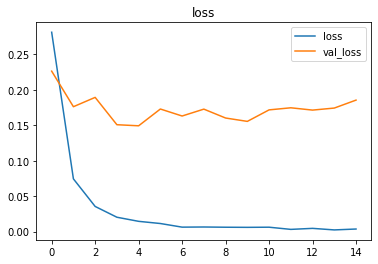

In [ ]:
df = pd.read_csv(log_path)

plt.plot(df["loss"])
plt.plot(df["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("loss")

Text(0.5, 1.0, 'accuracy')

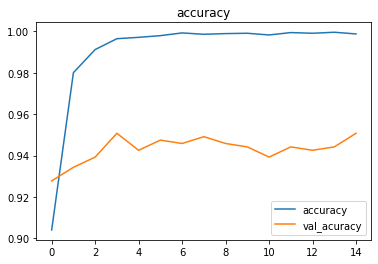

In [ ]:
plt.plot(df["accuracy"])
plt.plot(df["val_accuracy"])
plt.legend(["accuracy", "val_acuracy"])
plt.title("accuracy")

# 實際預測

In [ ]:
'''
# 圖片路徑
# img_path = 'cuttlefish_crawler_01779.jpg'
# img_path = 'cuttlefish_crawler_01814.jpg'
img_path = 'cuttlefish_crawler_01931.jpg'

# 丟入模型進行預測
img = cv2.imread(img_path)[:,:,::-1]
img_predict = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_predict = tf.keras.applications.resnet_v2.preprocess_input(img_predict)
img_predict = np.array(img_predict).reshape(1, IMG_SIZE, IMG_SIZE, 3)

from tensorflow.keras.models import load_model

model = load_model(model_path)
prob = model.predict(img_predict)[0]
print(prob, end='\n\n')

# 列出各種類的機率
for cls, p in zip(cls2idx.keys(), prob):
    print(cls, "的機率:", round(p, 5))
    
plt.imshow(img)
'''

'\n# 圖片路徑\n# img_path = \'cuttlefish_crawler_01779.jpg\'\n# img_path = \'cuttlefish_crawler_01814.jpg\'\nimg_path = \'cuttlefish_crawler_01931.jpg\'\n\n# 丟入模型進行預測\nimg = cv2.imread(img_path)[:,:,::-1]\nimg_predict = cv2.resize(img, (IMG_SIZE, IMG_SIZE))\nimg_predict = tf.keras.applications.resnet_v2.preprocess_input(img_predict)\nimg_predict = np.array(img_predict).reshape(1, IMG_SIZE, IMG_SIZE, 3)\n\nfrom tensorflow.keras.models import load_model\n\nmodel = load_model(model_path)\nprob = model.predict(img_predict)[0]\nprint(prob, end=\'\n\n\')\n\n# 列出各種類的機率\nfor cls, p in zip(cls2idx.keys(), prob):\n    print(cls, "的機率:", round(p, 5))\n    \nplt.imshow(img)\n'